https://youtu.be/nCMDZEScF-4

**Nuclei segmentation in whole slide H&E images**

using pre-trained StarDist model.

This is pretty much all taken from Dr. Sreenivas Bhattiprolu's github:
https://github.com/bnsreenu/python_for_microscopists/blob/master/281_Segmenting_WSI_using_StarDist.ipynb

In [76]:
!pip install stardist

In [77]:
# To read Tiff files on Colab we need to install imagecodecs library
!pip install imagecodecs  

In [78]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [79]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [80]:
import os

pth = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles'  # path of ndpi files
WSIs = [_ for _ in os.listdir(pth) if _.endswith('ndpi')]

pth_mat = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\10x\matfiles'
crop_mats = [_ for _ in os.listdir(pth_mat) if _.endswith('mat')]

In [82]:
imgs = []

for file in WSIs:
    im = imread(os.path.join(pth,file))
    imgs.append(im)

In [83]:
WSIs

['monkey_fetus_40_0105_ecm.ndpi',
 'monkey_fetus_40_0271_eye.ndpi',
 'monkey_fetus_40_0400_spinalcord.ndpi',
 'monkey_fetus_40_0420_brain.ndpi',
 'monkey_fetus_40_0432_bone.ndpi',
 'monkey_fetus_40_0450_heart.ndpi',
 'monkey_fetus_40_0730_kidney.ndpi']

In [84]:
for img in imgs:
    print(img.shape)

(29568, 32640, 3)
(30976, 36480, 3)
(29568, 36480, 3)
(30976, 36480, 3)
(28160, 34560, 3)
(28160, 36480, 3)
(25344, 36480, 3)


In [85]:
from scipy.io import loadmat

def get_crop_info(crop_mat_file_path, ratio) -> tuple:
    data = loadmat(crop_mat_file_path)

    offset = 1024/4 + 1024/8
    crop_width = 256
    crop_height = 256
    crop_x = int(data['crop_x']*ratio + offset)
    crop_y = int(data['crop_y']*ratio)

    return (crop_x, crop_y, crop_width)



In [86]:
ind = 0

mat_file_path = os.path.join(pth_mat, crop_mats[ind])
res20x=0.4416
res10x=1
ratio = res10x/res20x

crop_x, crop_y, tile_size = crop_info = get_crop_info(mat_file_path, ratio)

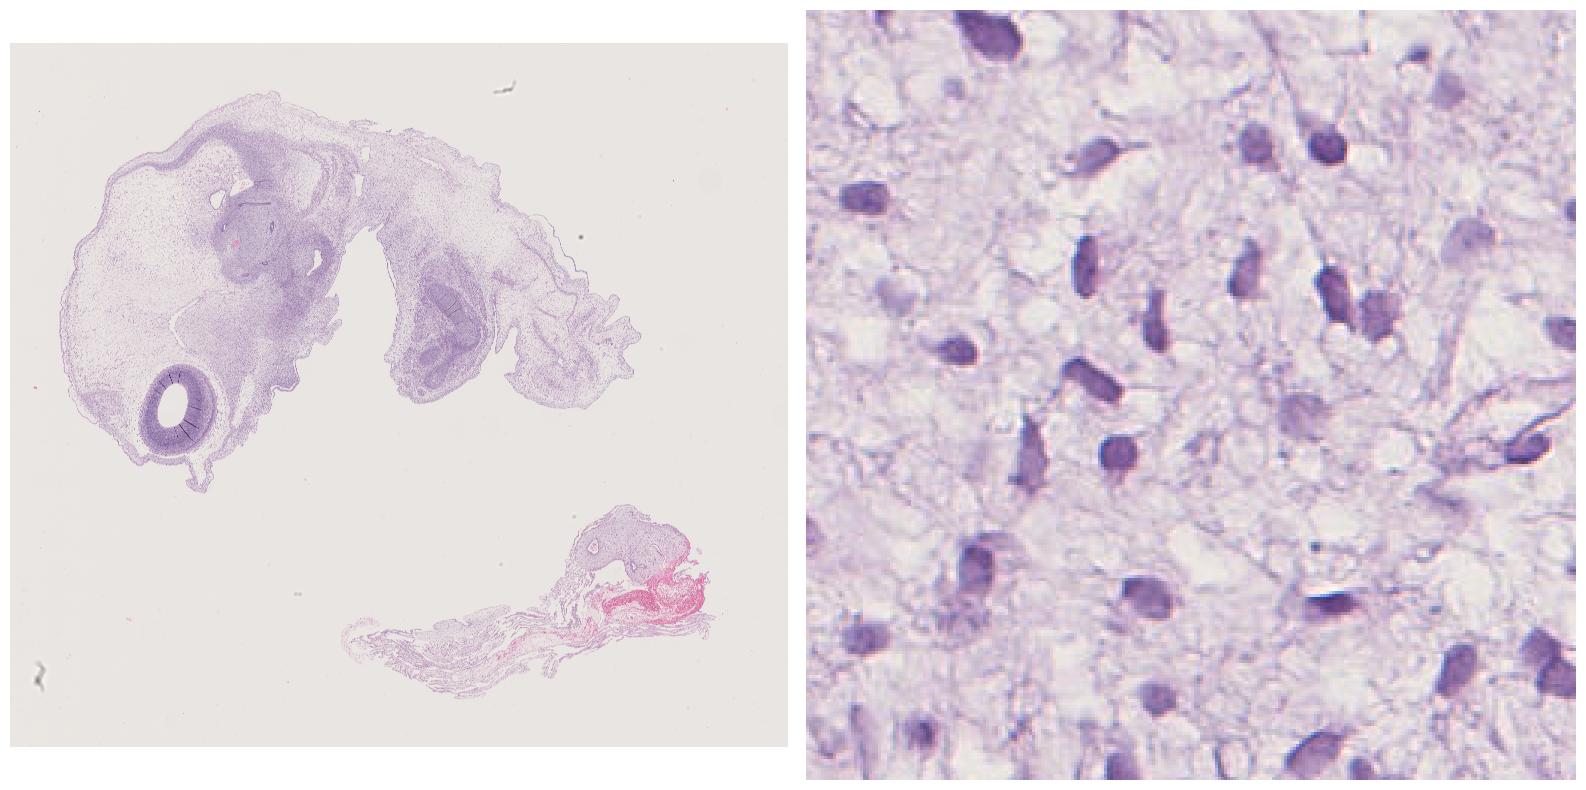

In [87]:
show_image(imgs[ind], crop_x, crop_y, tile_size)

In [88]:
model = StarDist2D.from_pretrained('2D_versatile_he')


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [89]:
def show_tile(tile, **kwargs):
    """Plot a single image."""
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile, **kwargs)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()

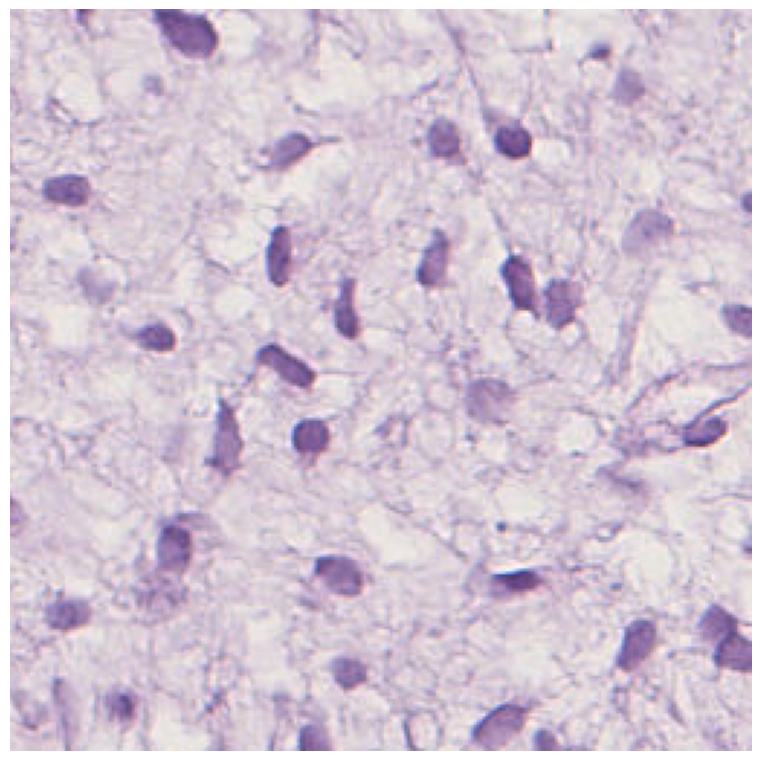

In [90]:
tiles_path = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\tiles256'
tiles = [_ for _ in os.listdir(tiles_path) if _.endswith('tif')]

tile = os.path.join(tiles_path, tiles[ind])
tile_im = imread(tile)

show_tile(tile_im)

In [275]:
from csbdeep.data import Normalizer, normalize_mi_ma
from csbdeep.utils import Path, normalize

class MyNormalizer(Normalizer):
    def __init__(self, mi, ma):
            self.mi, self.ma = mi, ma
    def before(self, x, axes):
        return normalize_mi_ma(x, self.mi, self.ma, dtype=np.float32)
    def after(*args, **kwargs):
        assert False
    @property
    def do_after(self):
        return False

mi, ma = np.percentile(tile_im, [5,95])                      # compute percentiles from low-resolution image
normalizer = MyNormalizer(mi, ma)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


75.0 108.0


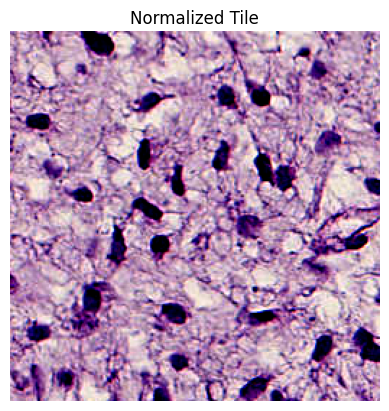

In [276]:
img = normalize(tile_im, 5,99)
# normalizer = None

mi, ma = np.percentile(tile_im, [0.05,0.95])
# normalizer = None
print(mi, ma)

normalized_tile = normalizer.before(tile, axes=None)

# Display the normalized image
plt.imshow(img)  # Assuming it's a grayscale image
plt.title('Normalized Tile')
plt.axis('off')
plt.show()

256


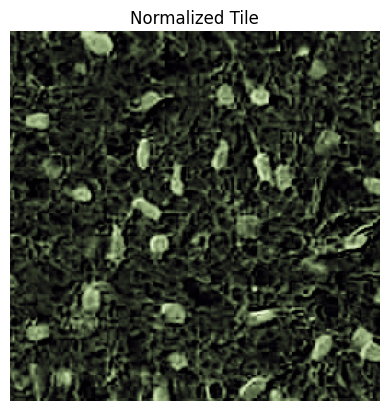

In [279]:
# using h channel extraction:

from normalizeStaining4 import normalizeStaining

img = np.array(tile_im)
print(len(img))
Inorm, H, E = normalizeStaining(img)

# Display the normalized image
plt.imshow(H.__invert__())
plt.title('Normalized Tile')
plt.axis('off')
plt.show()

In [263]:
H.shape

(256, 256, 3)

In [181]:
labels, polys = model.predict_instances(tile_im, normalizer)

ValueError: invalid axis '<', must be one of ['S', 'T', 'C', 'Z', 'Y', 'X'].

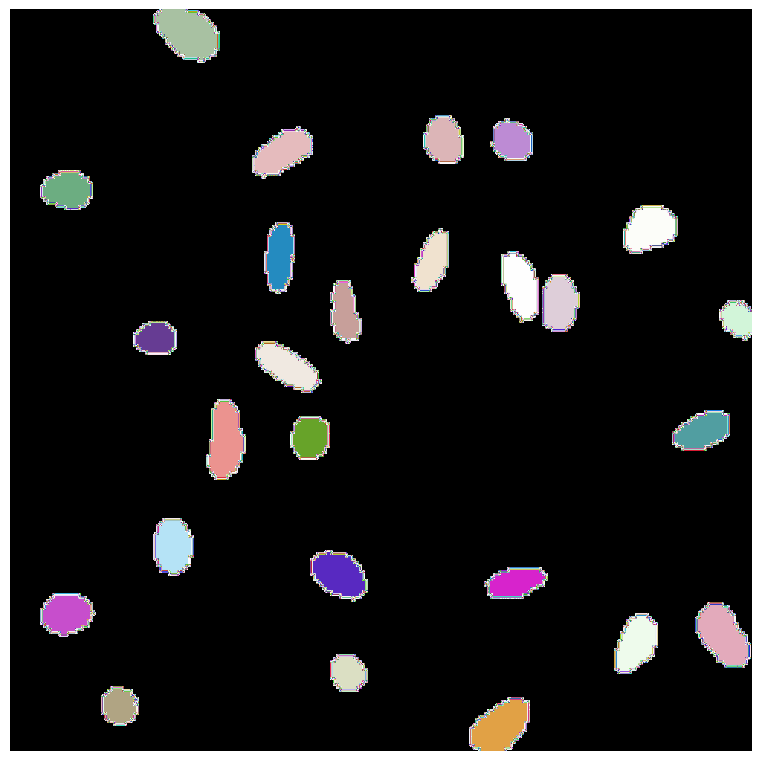

In [93]:
show_tile(labels, cmap = cmap)

In [95]:
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

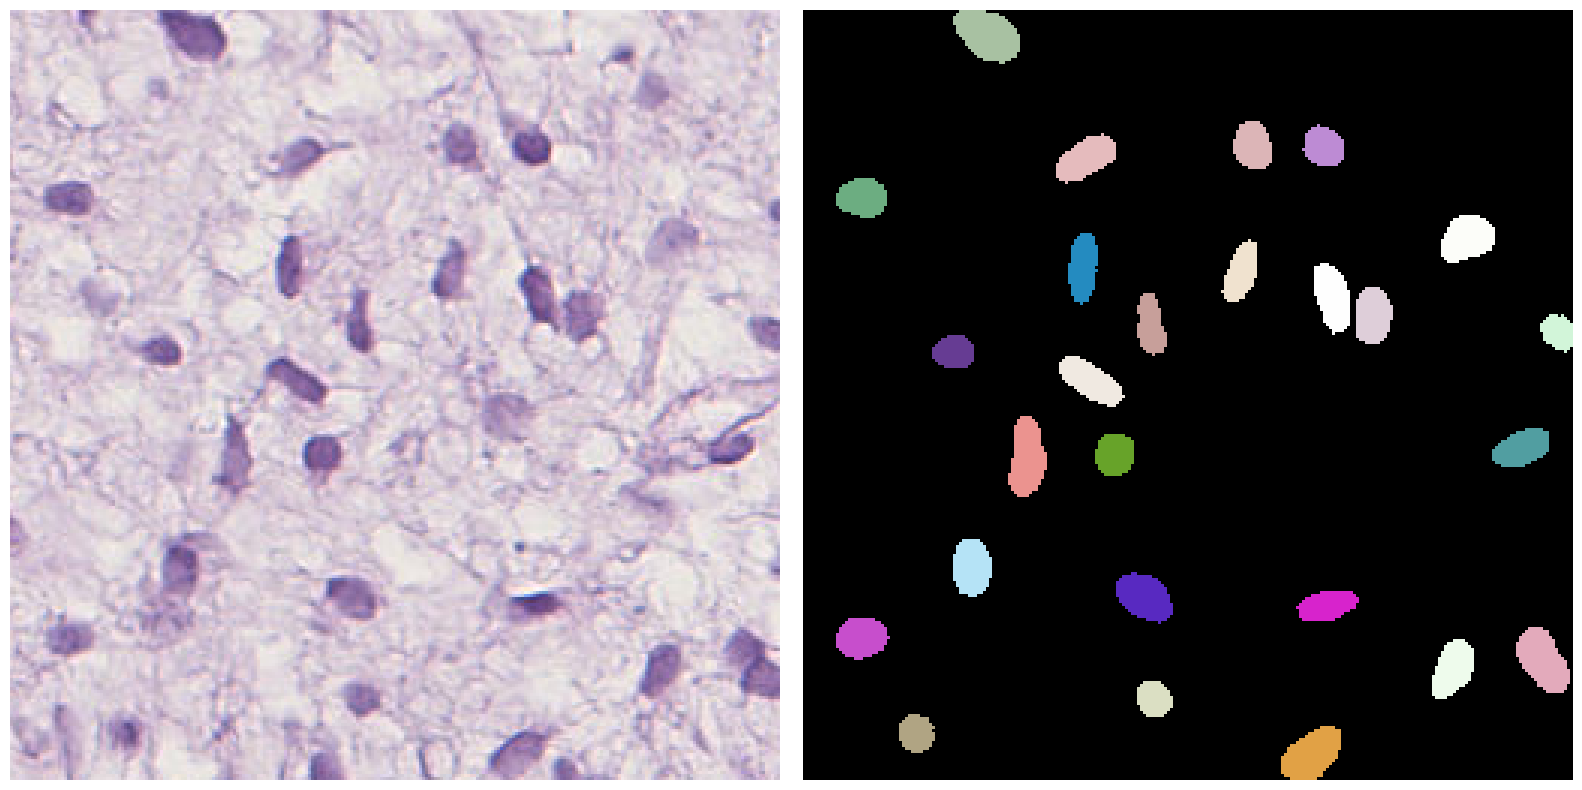

In [97]:

labels, polys = model.predict_instances(tile_im, normalizer=normalizer)
show_tile_segmented(tile_im, labels, cmap = cmap)

Now that we saw how it does on first tile, lets do it on all tiles and save

In [ ]:
import json
import geojson
from pathlib import Path

# correct format for geojson export file (centroids, contours, etc.)
type_info = Path(r"\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\qupath_json_format_file\monkey_fetus_40_0105_ecm.geojson")
info = json.load(open(type_info,'r'))#

In [320]:
cc = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


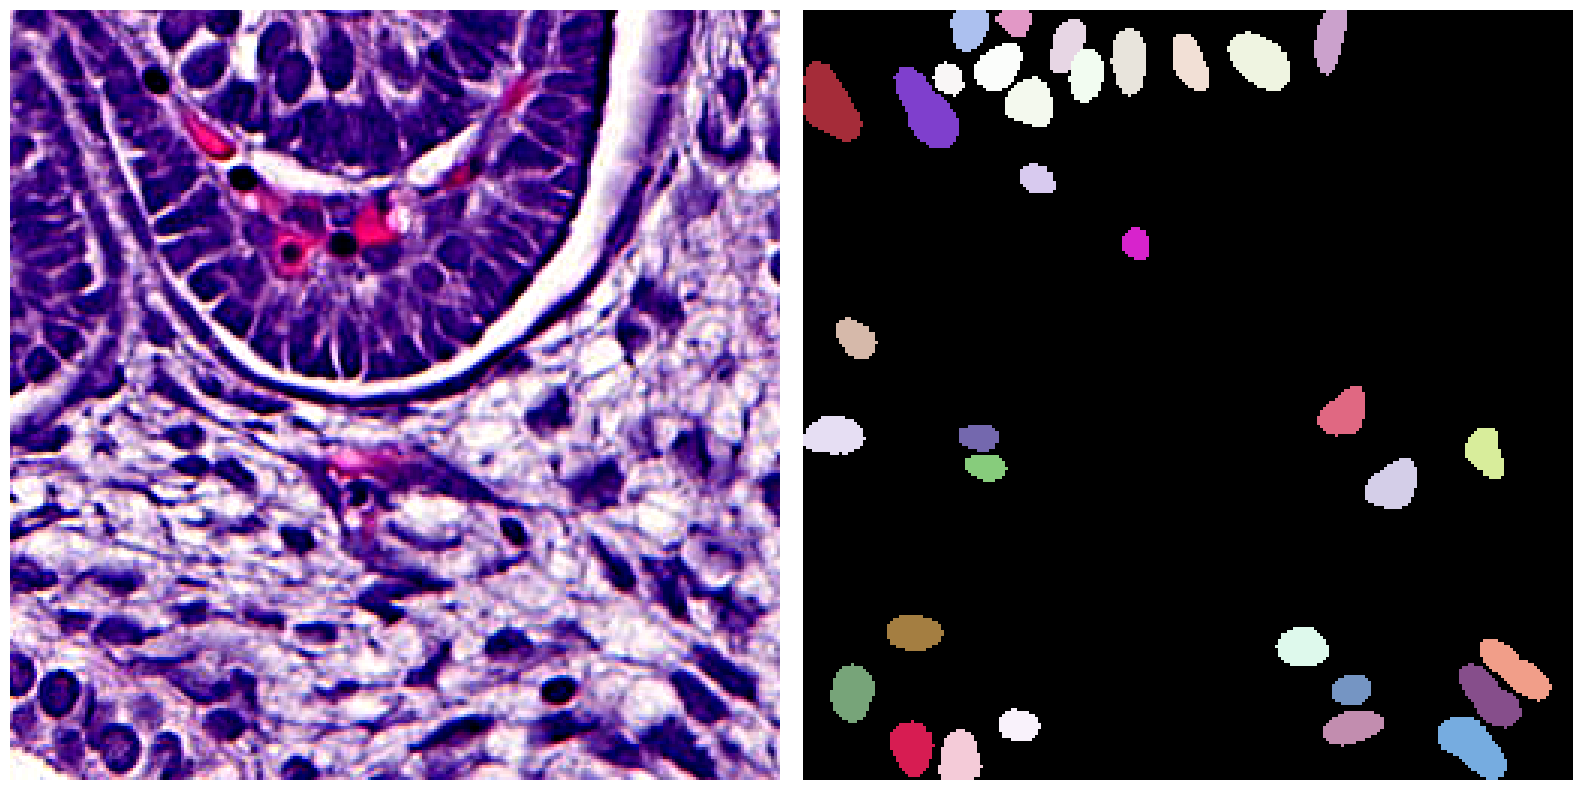

In [327]:
tiles_path = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\tiles256'
tiles = [_ for _ in os.listdir(tiles_path) if _.endswith('tif')]

tile = os.path.join(tiles_path, tiles[ind])

while cc < len(tiles):
    name = tiles[cc]
    tile_pth = os.path.join(tiles_path, name)
    tile = imread(tile_pth)

    tile = normalize(tile, 10, 95)
    normalizer = None

    result = model.predict_instances(tile, normalizer=normalizer)

    # save centroids and contours in geojson format to import into qupath
    coords = result[1]['coord']
    # print(len(coords[0][0]))
    contours = []
    for xy in coords:
        contour = []
        for i in range(len(xy[0])):
            p = [xy[0][i], xy[1][i]]  # [x, y]
            contour.append(p)
        contours.append(contour)

    data_stardist = []
    for i in range(len(result[1]['points'])):
        nucleus = result[1]['points'][i]
        contour = contours[i]
        both = [nucleus, contour]
        data_stardist.append(both)

    GEOdata = []

    for centroid, contour in data_stardist:
        # xy coordinates are swapped, so I reverse them here with xy[::-1]
        contour = [[int(coord) for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
        contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath

        # Create a new dictionary for each contour
        dict_data = {
            "type": "Feature",
            "id": "PathCellObject",
            "geometry": {
                "type": "Polygon",
                "coordinates": [contour]
            },
            "properties": {
                'objectType': 'annotation',
                'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
            }
        }

        GEOdata.append(dict_data)

    out_pth = Path(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\stardist_segmented_jsons')
    new_fn = name[:-4] + '.geojson'

   # with open(out_pth.joinpath(new_fn),'w') as outfile:
    #     geojson.dump(GEOdata,outfile)
    # print('Finished',new_fn)

    cc += 1

    labels, polys = model.predict_instances(tile, normalizer=normalizer)
    show_tile_segmented(tile, labels, cmap = cmap)
    break


In [ ]:
result = modbel.predict_instances(tile_im, normalizer=normalizer)

In [ ]:
coords = result[1]['coord']
# print(len(coords[0][0]))
contours = []
for xy in coords:
    contour = []
    for i in range(len(xy[0])):
        p = [xy[0][i], xy[1][i]]  # [x, y]
        contour.append(p)
    contours.append(contour)

print(len(contours))

In [ ]:
len(result[1]['points'])

In [ ]:
# combine points and contours into 1 list

data_stardist = []
for i in range(len(result[1]['points'])):
    nucleus = result[1]['points'][i]
    contour = contours[i]
    both = [nucleus, contour]
    data_stardist.append(both)

In [ ]:
for data in data_stardist:
    print(data)
    break

Now, need to format the points / contours into json format so that it can be read into Qupath for annotations

In [ ]:
import json
import geojson
from pathlib import Path

In [ ]:
# correct format
type_info = Path(r"\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\qupath_json_format_file\monkey_fetus_40_0105_ecm.geojson")
info = json.load(open(type_info,'r'))#

In [ ]:
info

In [ ]:
GEOdata = []

points = []
count = 0

for centroid, contour in data_stardist:
    # xy coordinates are swapped, so I reverse them here with xy[::-1]
    contour = [[int(coord) for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
    contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath
    points.append(centroid)

    # Create a new dictionary for each contour
    dict_data = {
        "type": "Feature",
        "id": "PathCellObject",
        "geometry": {
            "type": "Polygon",
            "coordinates": [contour]
        },
        "properties": {
            'objectType': 'annotation',
            'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
        }
    }

    GEOdata.append(dict_data)
    count += 1

print(count)

In [ ]:
for x in GEOdata:
    print(x)
    break

In [ ]:
# type(GEOdata[0])
type(GEOdata[0]['geometry']['coordinates'][0][0][0])

In [ ]:
print(GEOdata[:5])

In [ ]:
out_pth = Path(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\stardist_segmented_jsons')
new_fn = WSIs[ind][:-5] + '.geojson'

print(new_fn)
with open(out_pth.joinpath(new_fn),'w') as outfile:
    geojson.dump(GEOdata,outfile)
print('Finished',new_fn)